In [3]:
import utility
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True
# mpl.rcParams['font.size'] = 22
plt.rcParams['font.family'] = 'serif'  # Use Computer Modern fonts
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amsfonts}'


replicates = 10_000
confidence = 68

# Define the custom orders
SYSTEM_ORDER = ["p38", "A2A", "ptp1b", "tyk2", "thrombin", "mcl1", "CyclophilinD", "SAMPL6-OA"]
FORCE_FIELD_ORDER = ['espaloma-0.3.1', 'gaff-2.11', 'openff-2.0.0']
FF_NAME = {
    'espaloma-0.3.1': 'Espaloma', 
    'gaff-2.11': 'GAFF',
    'openff-2.0.0': 'OpenFF',
}
SYSTEM_NAME = {
    "p38": "P38", 
    "A2A": "A2A",
    "ptp1b": "PTP1B",
    "tyk2": "TYK2",
    "thrombin": "Thrombin",
    "mcl1": "MCL1",
    "CyclophilinD": "CyclophilinD",
    "SAMPL6-OA": "SAMPL6-OA"
}

# Define color palette
palette = sns.color_palette("Set2")[:3]  # colorblind-friendly


def to_latex(string):
    try:
        return r"$\mathrm{" + string.replace("_", r"\_").replace("-", r"\text{-}").replace(" ", r"\ ") + r"}$"
    except:
        raise Exception(string)


def plot_stats(ax, data, contribution='spearman', legend = 'auto'):
    dat2work = data.copy()
    
    SYSTEM_ORDER_LATEX = [to_latex(SYSTEM_NAME[s]) for s in SYSTEM_ORDER]
    FORCE_FIELD_ORDER_LATEX = [to_latex(FF_NAME[f]) for f in FORCE_FIELD_ORDER]
    
    values = dat2work[contribution].apply(utility.get_numerical_values)
    values = np.array(list(values.values))
    
    ci_low = []
    ci_high = []
    nominal_value = []
    for v, l, h in values:
        if v:
            nominal_value.append(v)
            ci_low.append(v - l)
            ci_high.append(h - v)
        else:
            nominal_value.append(np.nan)
            ci_low.append(np.nan)
            ci_high.append(np.nan)

    dat2work['ci_low'] = ci_low
    dat2work['ci_high'] = ci_high
    dat2work[contribution] = nominal_value
    
    # dat2work['ci_low'] = values[:,0] - values[:,1]
    # dat2work['ci_high'] = values[:,2] - values[:,0]
    # dat2work['value'] = values[:,0]

    
    dat2work['source'] = pd.Categorical(
        dat2work['source'].replace(SYSTEM_NAME).map(to_latex), categories=SYSTEM_ORDER_LATEX, ordered=True
    )
    dat2work['force_field'] = pd.Categorical(
        dat2work['force_field'].replace(FF_NAME).map(to_latex), categories=FORCE_FIELD_ORDER_LATEX, ordered=True
    )

    # Sort the DataFrame based on the custom orders
    dat2work = dat2work.sort_values(by=['source', 'force_field']).reset_index(drop=True)

    bar_plot = sns.barplot(
        data=dat2work,
        x="source",
        y=contribution,
        hue='force_field',
        width=0.85,
        ax=ax,
        legend=legend,
        hue_order=FORCE_FIELD_ORDER_LATEX,
        palette=palette,
        order=SYSTEM_ORDER_LATEX,
    )

    bar_positions = sorted([patch.get_x() + patch.get_width() / 2 for patch in bar_plot.patches])#[:-num_unique_ff])
    dat2work.dropna(inplace=True)
    ax.errorbar(
        x=bar_positions,  # Position of the bar
        y=dat2work[contribution],
        yerr=[dat2work['ci_low'], dat2work['ci_high']],
        fmt='none',  # No marker
        c='gray',
        capsize=5
    )

    if contribution == 'pearson':
        ax.set(
            ylabel=r'$\rho$'
        )
    if contribution == 'spearman':
        ax.set(
            ylabel=r'$r_S$'
        )
    if contribution == 'kendall':
        ax.set(
            ylabel=r'$\tau$'
        )
        
    ax.set(xlabel='')
    ax.tick_params(axis='x', rotation=90)


def plot_ff(ax, data, contribution, legend = None):
    
    dat2work = data.copy()
    
    SYSTEM_ORDER_LATEX = [to_latex(SYSTEM_NAME[s]) for s in SYSTEM_ORDER]
    FORCE_FIELD_ORDER_LATEX = [to_latex(FF_NAME[f]) for f in FORCE_FIELD_ORDER]

    dat2work['source'] = pd.Categorical(
        dat2work['source'].replace(SYSTEM_NAME).map(to_latex), categories=SYSTEM_ORDER_LATEX, ordered=True
    )
    dat2work['force_field'] = pd.Categorical(
        dat2work['force_field'].replace(FF_NAME).map(to_latex), categories=FORCE_FIELD_ORDER_LATEX, ordered=True
    )
    
    # Sort the DataFrame based on the custom orders
    dat2work = dat2work.sort_values(by=['source', 'force_field']).reset_index(drop=True)

    sns.boxplot(
        x="source",
        y=contribution,
        hue='force_field',
        data=dat2work,
        whis=1.5, #[0, 100],
        width=0.85,
        ax=ax,
        legend=legend,
        hue_order=FORCE_FIELD_ORDER_LATEX,
        palette=palette,
        order=SYSTEM_ORDER_LATEX,
    )
    if contribution == 'diff':
        ax.set(
            ylabel=r'$\Delta G_\mathrm{calc} - \Delta G_\mathrm{exp} \mathrm{~[kcal/mol]}$'
        )

    ax.set(xlabel='')
    ax.tick_params(axis='x', rotation=90)


def get_data(CALC_TYPE):
    BindFlowData = pd.read_csv("../data/simulation/bindflow/gather/BindFlow.csv")

    columns = [
        "system",
        "ligand",
        "replica",
        "sample",
        "exp_dG",
        "exp_dG_error",
        f"simulation_{CALC_TYPE}_espaloma-0.3.1",
        f"simulation_{CALC_TYPE}_gaff-2.11",
        f"simulation_{CALC_TYPE}_openff-2.0.0",
    ]
    BindFlowData = BindFlowData[columns]


    BindFlowData.rename(
        columns={
            "system": "source",
            f"simulation_{CALC_TYPE}_espaloma-0.3.1": "simulation_espaloma-0.3.1",
            f"simulation_{CALC_TYPE}_gaff-2.11": "simulation_gaff-2.11",
            f"simulation_{CALC_TYPE}_openff-2.0.0": "simulation_openff-2.0.0",
        },
        inplace=True
    )

    mean = BindFlowData.groupby(["source", "ligand"]).mean().reset_index().drop(columns=["replica", "sample"])
    sem = BindFlowData.groupby(["source", "ligand"]).sem().reset_index().drop(columns=["replica", "sample"])

    # Filter DataFrame
    mask = mean["simulation_espaloma-0.3.1"].notna()


    mean = mean[mask]
    sem = sem[mask]


    sem.rename(
        columns={
            "simulation_espaloma-0.3.1": "sem_espaloma-0.3.1",
            "simulation_gaff-2.11": "sem_gaff-2.11",
            "simulation_openff-2.0.0": "sem_openff-2.0.0",
        },
        inplace=True
    )

    sem.drop(columns=["exp_dG", "exp_dG_error"], inplace=True)

    df_merge = pd.merge(mean, sem, on=["source", "ligand"])
    return df_merge


def full_plot(stats_data, diff_data, CALC_TYPE):
    scale = 2  
    sns.set_theme(
        style="ticks", 
        font_scale=scale,
        rc={
            "axes.linewidth": 1.2 * scale,
            # "lines.linewidth": 1.1 * scale
            }
    )

    # Make ticks thicker/longer in proportion to font scaling
    plt.rcParams.update({
        "xtick.major.size": 5 * scale,   # length of major ticks
        "ytick.major.size": 5 * scale,
        "xtick.major.width": 1.2 * scale,  # thickness of major ticks
        "ytick.major.width": 1.2 * scale,
    })
    
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(19, 9), sharex=True)

    plot_stats(ax=axs[0,0],data=stats_data, contribution='pearson', legend=None)

    plot_stats(ax=axs[0,1],data=stats_data, contribution='kendall', legend=None)
    
    plot_stats(ax=axs[1,0],data=stats_data, contribution='spearman', legend=None)


    
    axs[0, 1].sharey(axs[0, 0])
    axs[1, 0].sharey(axs[0, 0])
    axs[0,0].set(ylim=[0,1.05])
    axs[0,0].set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    axs[0,1].set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    axs[1,0].set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])


    axs[1,1].axhline(0, color='gray', linestyle='--')

    plot_range = [-1*v for v in range(5, 1, -1)] + list(range(15))
    axs[1,1].fill_between(plot_range, -1, 1, color='black', alpha=0.2)
    axs[1,1].fill_between(plot_range, -2, 2, color='gray', alpha=0.2)


    plot_ff(ax=axs[1,1], data=diff_data,contribution='diff', legend='auto')

    # Get the current legend and customize it
    axs[1,1].get_legend().set_title(None)

    # Add subplot labels
    labels = ['a', 'b', 'c', 'd']
    for ax, label in zip(axs.flat, labels):
        if label in ['b', 'd']:
            if any(axs[1,1].get_yticks() <= -10):
                x_position = -0.2
                wspace = 0.25
            else:
                x_position = -0.15
                wspace = 0.2
        else:
            x_position = -0.12
        
        ax.text(x_position, 1.05, f"$\\mathbf{{{label}}}$", transform=ax.transAxes, 
                fontsize=30, va='top', ha='right')

    fig.subplots_adjust(wspace=wspace, hspace=0.07)

    fig.savefig(f'summary/stats/{CALC_TYPE}-stats.pdf',
            bbox_inches="tight",
            pad_inches=0.05,
            transparent=False)

Failed to find the pandas get_adjustment() function to patch
Failed to find the pandas get_adjustment() function to patch
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to patch pandas - PandasTools will have limited functionality
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - Pand

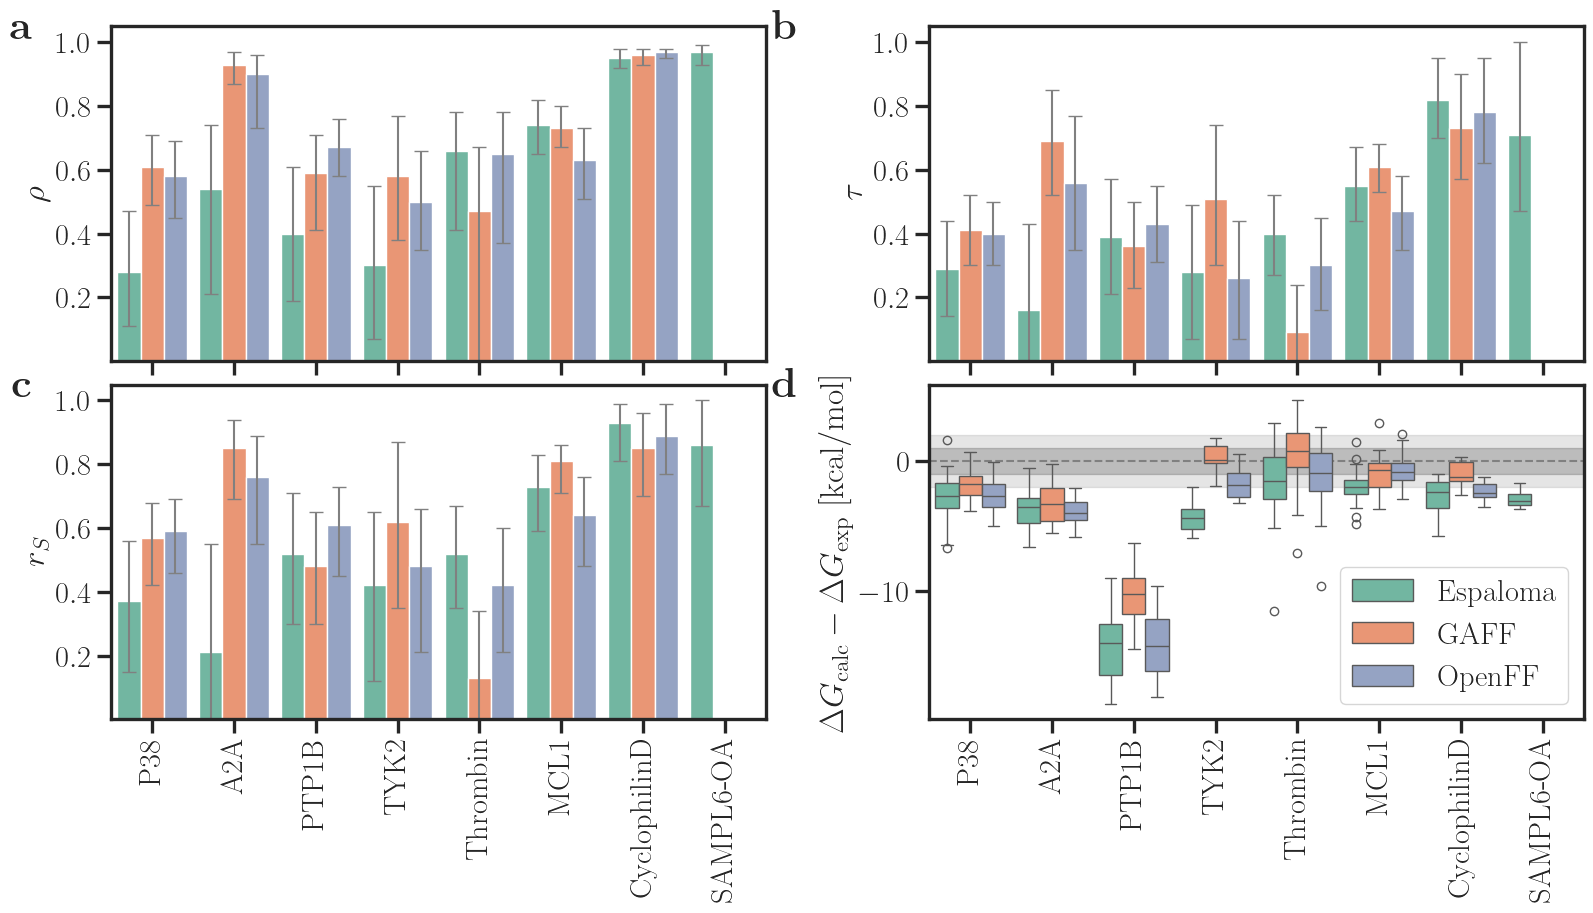

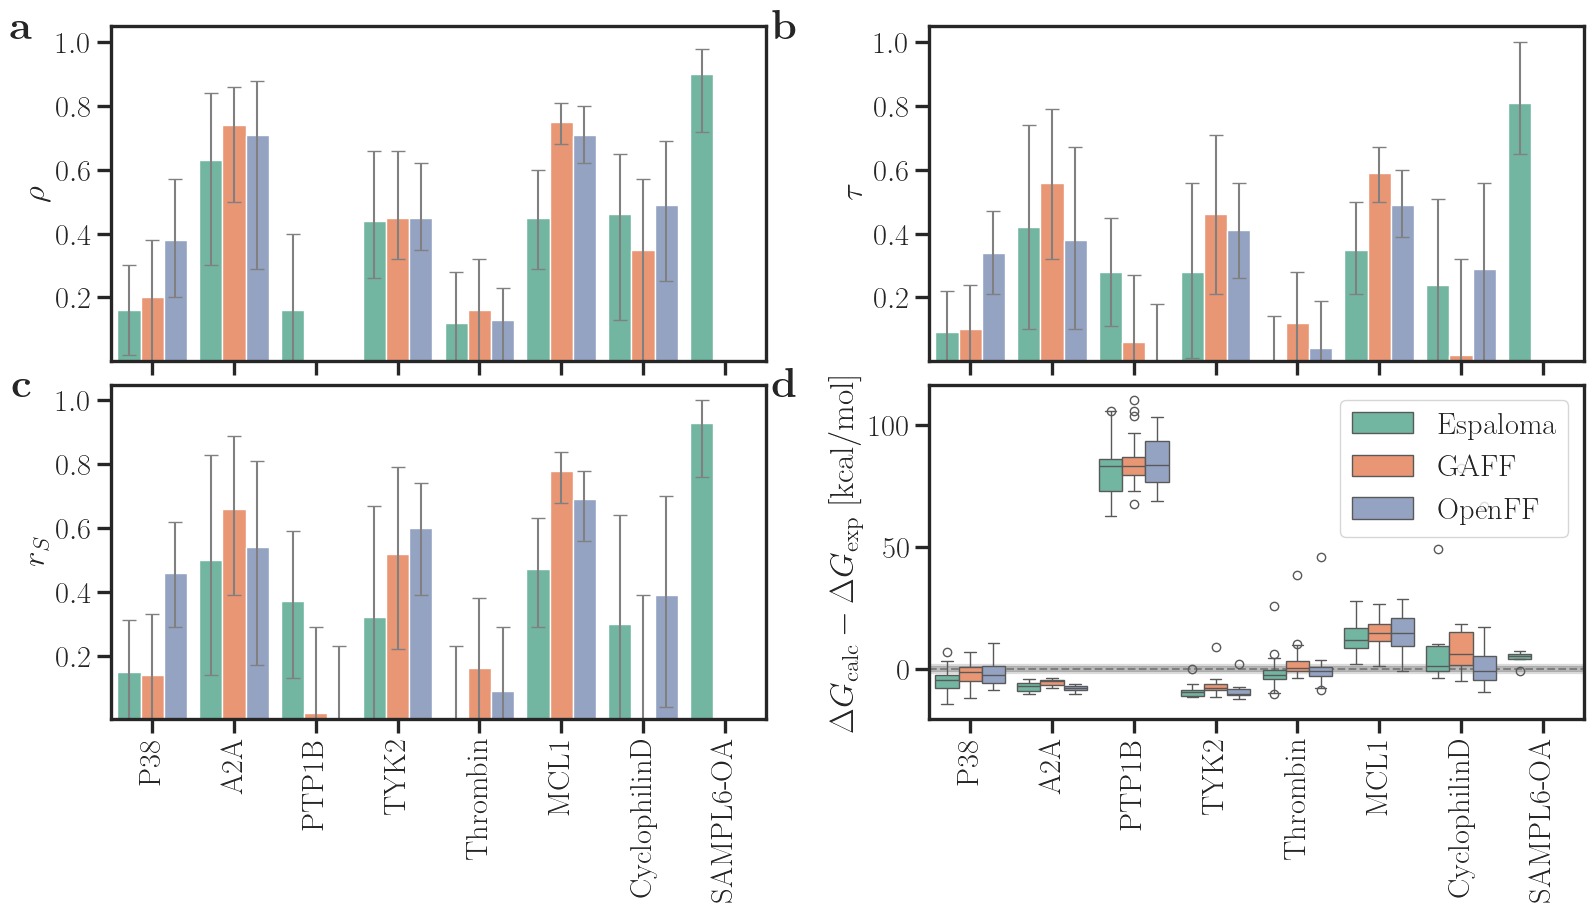

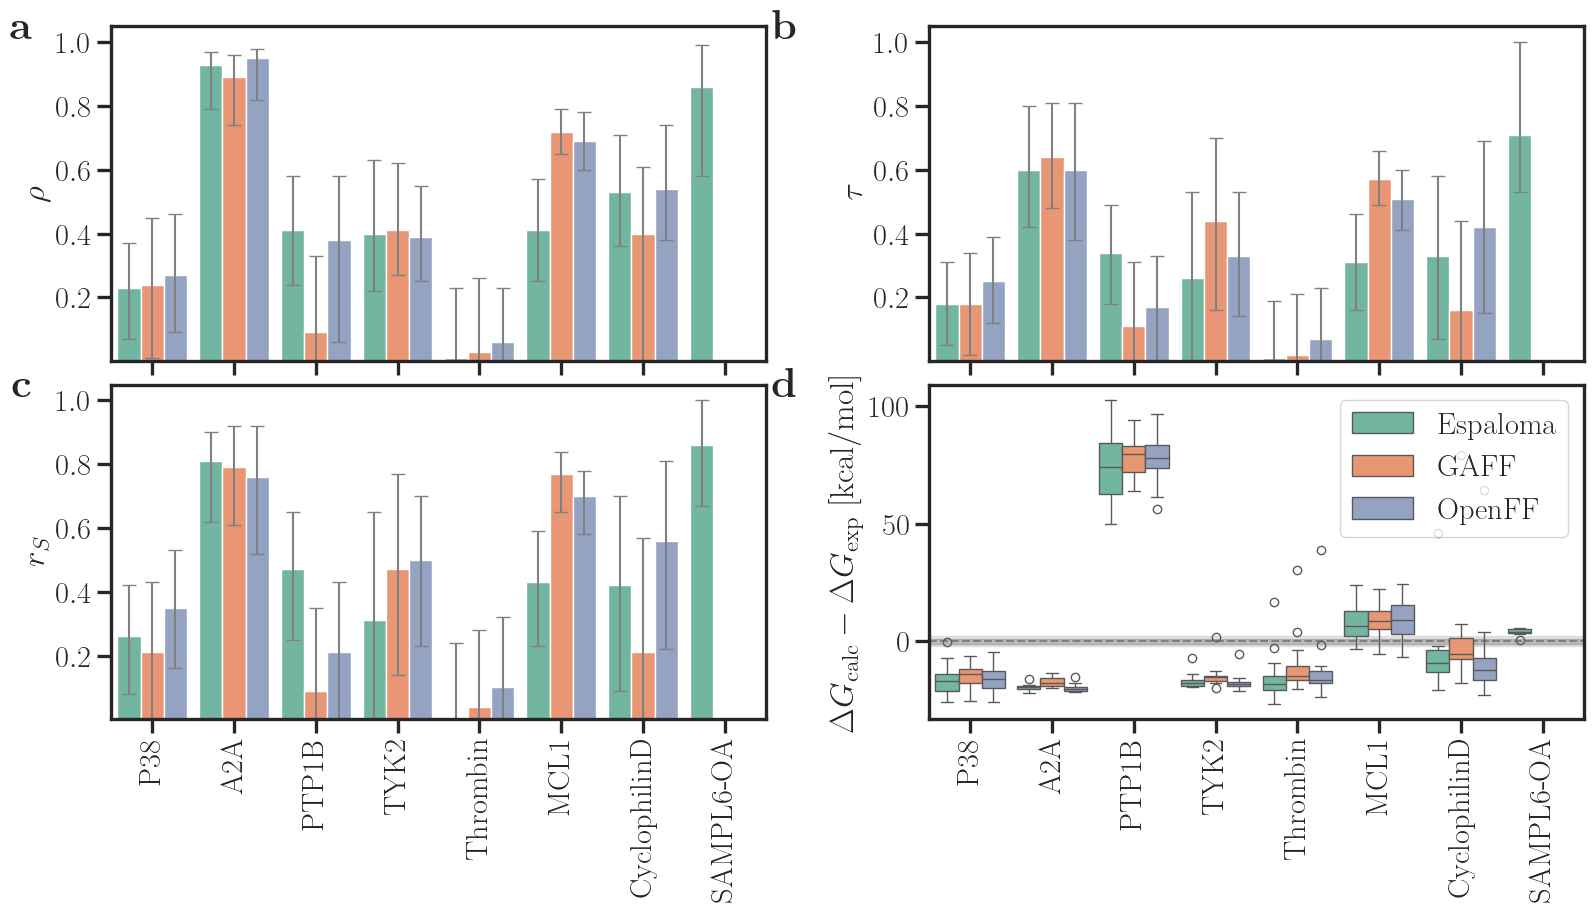

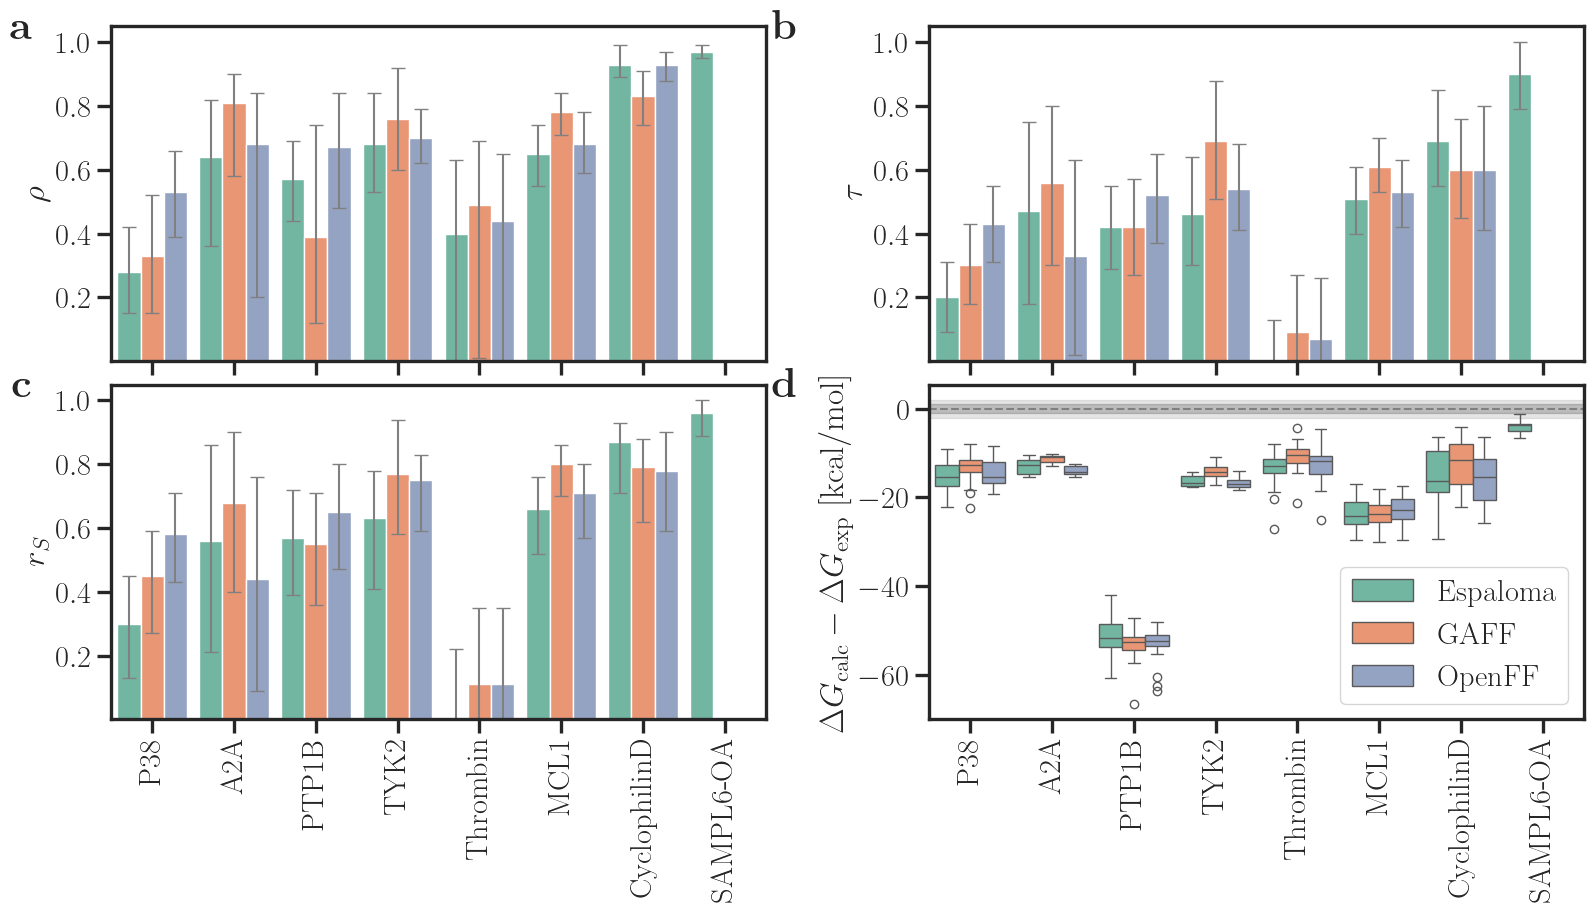

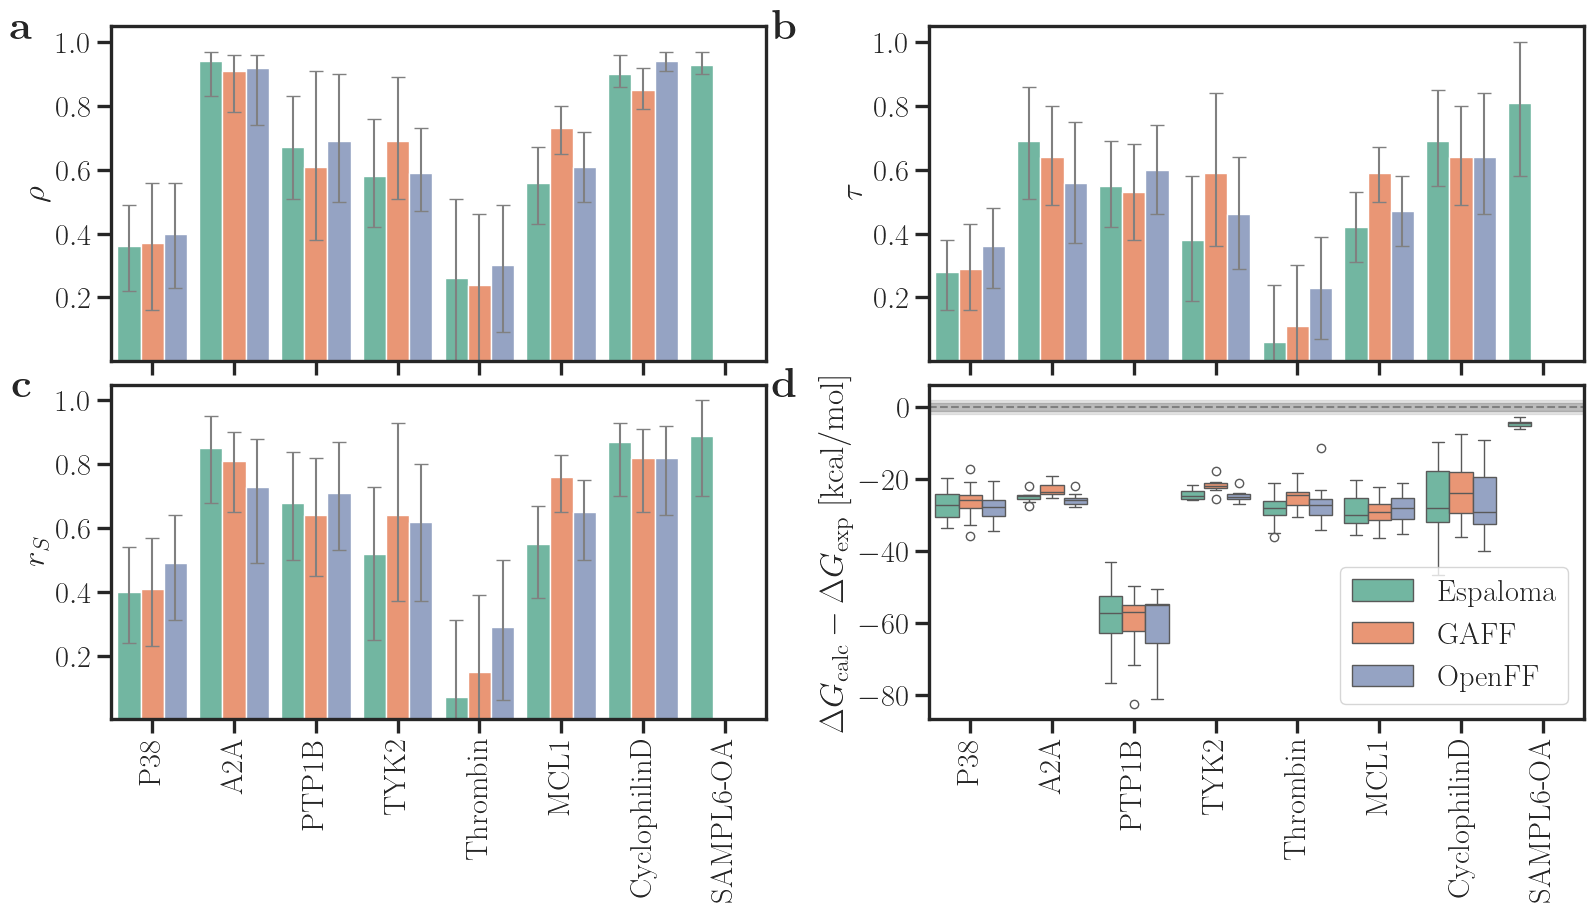

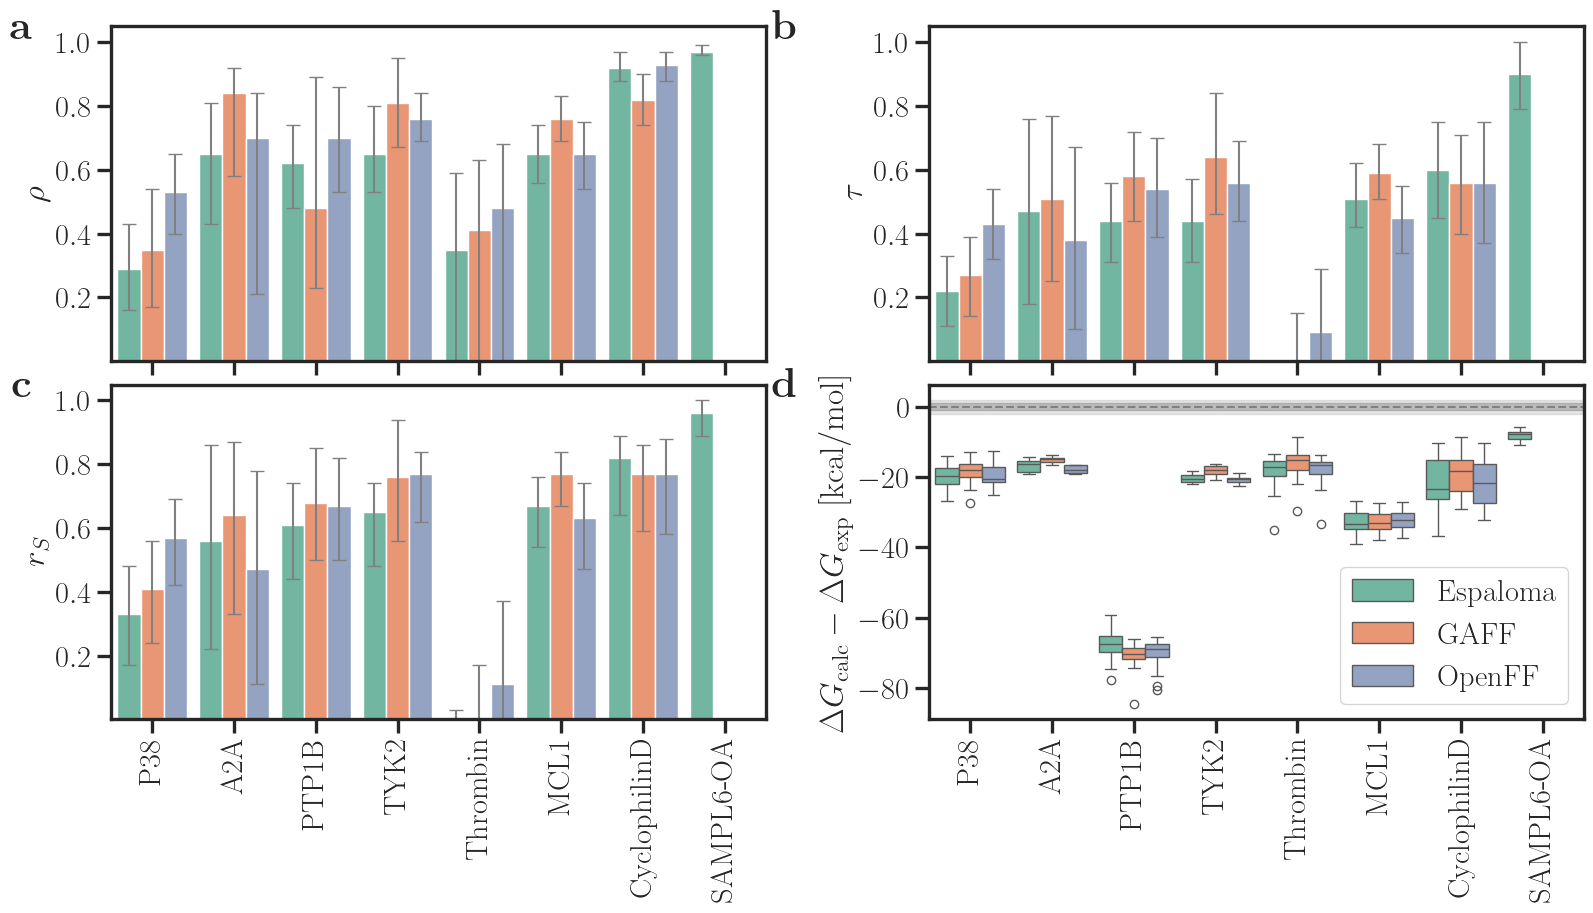

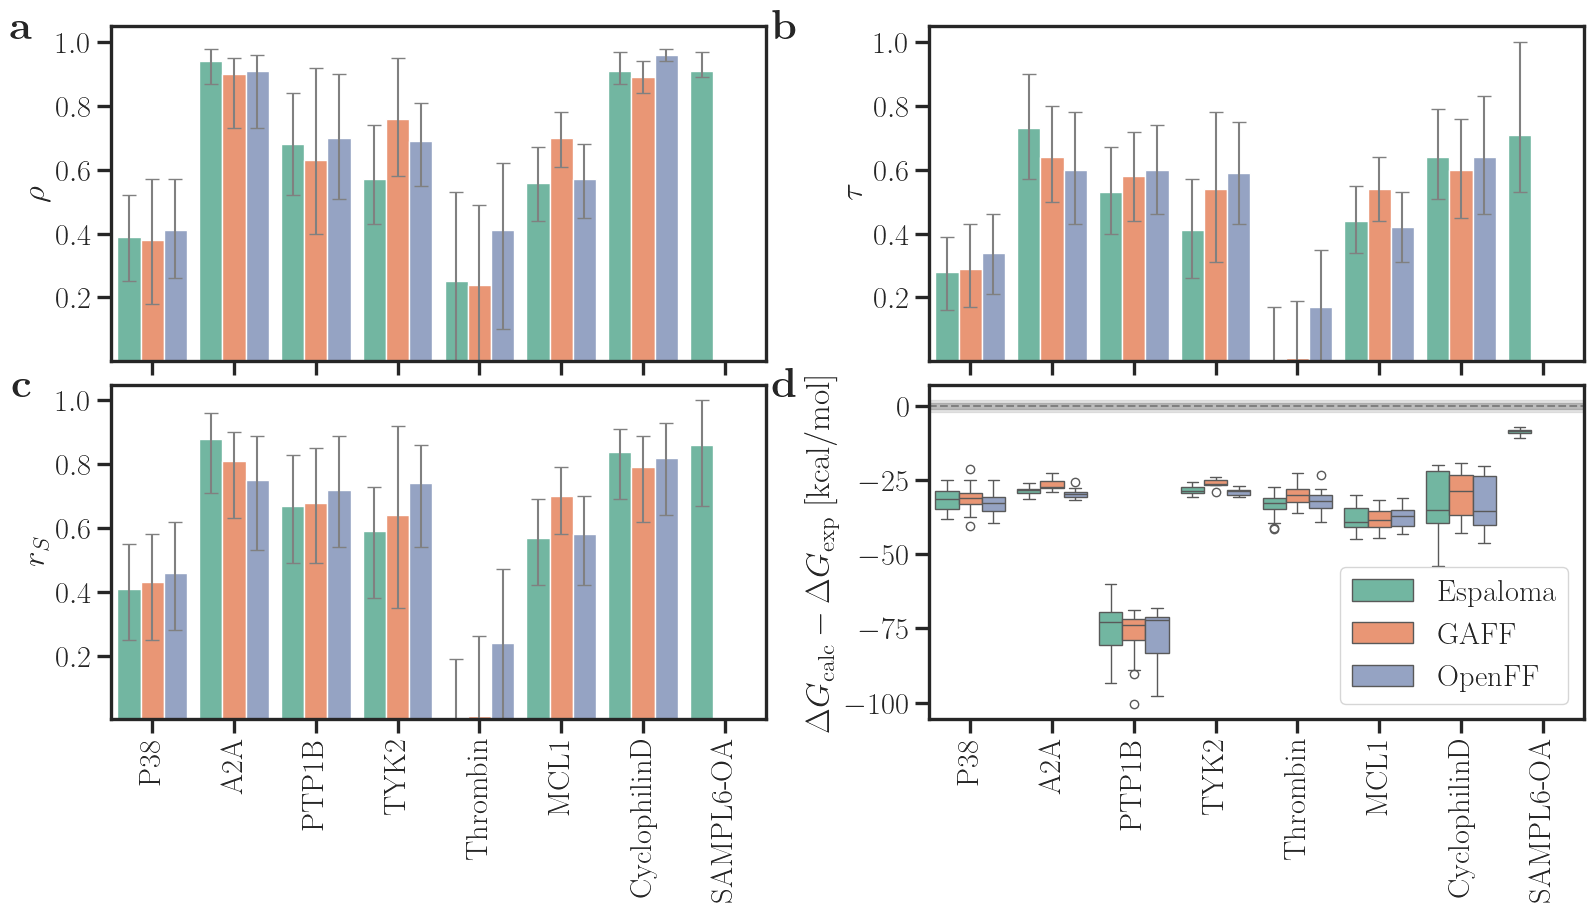

In [4]:
for CALC_TYPE in ["mbar", "dg-c2-pb", "dg-c2-gb", "dg-ie-pb", "dg-ie-gb", "dh-pb", "dh-gb"]:
    df_merge = get_data(CALC_TYPE=CALC_TYPE)

    stats_data = pd.DataFrame()
    for system in SYSTEM_ORDER:
        system_name = SYSTEM_NAME[system]
        df = utility.get_all_stats(df_merge[df_merge["source"] == system], replicates=replicates, confidence=confidence)
        df["source"] = system_name
        stats_data = pd.concat([stats_data, df])
    stats_data["force_field"] = [s.split("simulation_")[-1] for s in stats_data.index]

    diff_data = df_merge[["source",	"ligand"]]
    for column in df_merge.columns:
        if column.startswith("simulation_"):
            ff = column.split("simulation_")[-1]
            diff_data[ff] = df_merge[column] - df_merge["exp_dG"]

    diff_data

    diff_data = pd.melt(
        diff_data,
        id_vars=["source", "ligand"],  # Columns to keep fixed
        var_name="force_field",                   # Name for the new "variable" column
        value_name="diff"                  # Name for the new "value" column
    )
    full_plot(
        stats_data=stats_data,
        diff_data=diff_data,
        CALC_TYPE=CALC_TYPE
        )
    